In [2]:
using JuMP  
using Ipopt
using Plots
using LaTeXStrings
using LinearAlgebra

In [3]:
x_labels = ["x₁" "x₂" "x₃" "x₄" "x₅" "x₆" "x₇" "x₈" "x₉" "x₁₀" "x₁₁" "x₁₂" "x₁₃" "x₁₄" "x₁₅" "x₁₆" "x₁₇" "x₁₈" "x₁₉" "x₂₀"]

sin = 2.0

n = 5 # 3 ≤ n ≤ 20
x0_def = (1/n)*ones(n)

a = [i for i in 1:n] 
b = [i^2 for i in 1:n]  
d = [-1; [-2 for i in 1:(n-2)]; -1]
d1 = [1 for i in 1:(n-1)]
matrix_M = SymTridiagonal(d, d1);


In [4]:
mutable struct incognitas
    t; x; s ; y ; u 
end

function μ(s, i) 
    i = trunc(Int, i)
    return (a[i]*s)/(b[i]+s)
end

function  M(e, x, i)
    i = trunc(Int, i)
    return e*sum(matrix_M[i,:].*x)
end 

function dS(x, s, u)
    mu = (a*s)./(b.+s)
    return (u*(sin-s))-sum(mu.*x)
end

function H(x)
    N = sum(x)
    lnN = log(N)
    return (sum(x.*(log.(x).-lnN)))/N
end

function P(u, x)
    return u*sum(x)
end;



In [5]:
function CHEMOSTAT(eps= 0.1, tf = 30.0, umax = 5.0, alpha = 0.2, x0 = x0_def, s0 = 1, y0=0 , nsteps=150, tol=1e-8, display=true)

    # Create JuMP model, using Ipopt as the solver
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => display ? 5 : 1))
    set_optimizer_attribute(sys,"tol", tol)
    set_optimizer_attribute(sys,"constr_viol_tol", tol)
    set_optimizer_attribute(sys,"max_iter",800)

    register(sys, :μ, 2, μ, autodiff=true)
    register(sys, :M, 3, M, autodiff=true)
    register(sys, :dS, 3, dS, autodiff=true)
    register(sys, :H, 1, H, autodiff=true)
    register(sys, :P, 2, P, autodiff=true)
    

    # Constants
    N  = nsteps     # Grid size
    @variables(sys, begin
                 x[1:n,1:N+1] ≥ 0   
                 s[1:N+1] ≥ 0
                 y[1:N+1] # cost
          0.0 ≤  u[1:N+1] ≤ umax
    end)
    T  = tf
    Δt = T/(N+1)
    e  = eps
    a = alpha
    
    # Objective
    @NLobjective(sys, Min, y[N+1])

    # Boundary constraints
    @constraints(sys, begin
        con_x0,   x[:,1] == x0
        con_s0,   s[1]   == s0 
        con_y0,   y[1]   == y0 
    end)


    # Dynamics
    @expression(sys, dx[i = 1:n, j = 1:N+1], ((μ(s[j],i) - u[j]) * x[i,j]) + M(e,x[:,j],i) ) 

    @expression(sys, ds[j = 1:N+1], dS(x[:,j],s[j],u[j]) )

    @expression(sys, dy[j = 1:N+1], a*H(x[:,j]) - (1.0-a)*P(u[j],x[:,j]) )
   

    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx[i=1:n,j=1:N], x[i,j+1] == x[i,j] +  0.5 * Δt *(dx[i,j+1] + dx[i,j])
        con_ds[j=1:N],         s[j+1] == s[j]  + 0.5 * Δt * (ds[j+1]  +  ds[j])
        con_dy[j=1:N],         y[j+1] == y[j]  + 0.5 * Δt * (dy[j+1]  +  dy[j])

    end)                      
    
    
    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x  = value.(x)[:,:]
    s  = value.(s)[:]
    y  = value.(y)[:]
    u  = value.(u)[:]
    t  = (0:N) * value.(Δt)
        
    
    return incognitas(t, x, s , y, u)
    
    
end;

In [60]:
# Resolution 

eps    = 0.1
tf     = 30.0
umax   = 5.0
alpha  = 1.0 # min ∫αH + (1-α)(-P) 
#-> when α = 0.0, 0.7 and 0.4 to 0.1, set tol->1e-5 or it doesn't converge
#-> for α = 0.0 diff tolerances give diff solutions


#x₁ = [0.15,0.2,0.2,0.2, 0.1]
#x₂ = [0.001,0.4,0.01,0.01,0.01] 
#x₃ = [0.001,0.01,0.4,0.01,0.01] 
#x₄ = [0.001,0.01,0.01,0.4,0.01] 
#x₅ = [0.001,0.01,0.01,0.01,0.4] 

x0     = [0.01,0.2,0.01,0.01,0.01] #[0.15,0.2,0.2,0.2, 0.1]
s0     = 1-sum(x0)
y0     = 0
nsteps = 200   #200
tol    = 1e-5 #1e-5


sol = CHEMOSTAT(eps, tf, umax, alpha, x0, s0, y0, nsteps, tol);

ErrorException:   The model was not solved correctly.

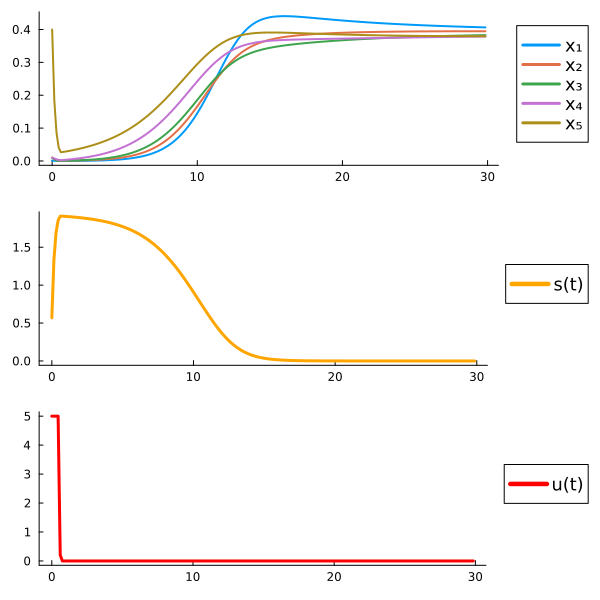

In [51]:
t, s, u  = sol.t, sol.s, sol.u
x = transpose(sol.x)
label = reshape(x_labels[1:n],(1,:))
p1 = plot(t, x, label=label, lw=2)
p2 = plot(t, s, label="s(t)", lw=3, linecolor="orange")
p3 = plot(t, u, label="u(t)", lw=3, linecolor="red")
p = plot(p1, p2, p3, layout=(3,1), size=(600, 600),legendfont = font(12), grid=false, background_color_legend="white", legend=:outerright)#, background_color=:transparent)

In [69]:
# savefig(p, "CDC/alpha0-9/sol_OCP_x1.png")

"/Users/claudiaalvarez/Documents/github/Journees-MODE/CDC/alpha0-9/sol_OCP_x1.png"